In [1]:
%matplotlib inline
import sys, os, time, math, csv
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

#migration-lib
sys.path.append(os.path.join(os.getcwd(),"migration-lib"))
import MigrationDataUSA
import MigrationModels
import EvaluationMethods

## Load migration data

In [12]:
migration_data = [
    np.load("data/migration/usa_migrationMatrix_%d.npy" % (year))
    for year in range(2004,2015)
]

for T in migration_data:
    np.fill_diagonal(T, 0)
    
outgoing_migration_data = [
    np.sum(T, axis=1)
    for T in migration_data
]

incoming_migration_data = [
    np.sum(T, axis=0)
    for T in migration_data
]

In [3]:
migration_counties = []
f = open("data/migration/largestCountyIntersection_2004_2014.txt")
for line in f.read().strip().split("\n"):
    migration_counties.append(line)
f.close()

In [7]:
populationDf = pd.read_csv("data/county_population_2004_2014.csv", dtype={"FIPS":str})
populationDf = populationDf.set_index("FIPS")

populationVectors = [populationDf[str(year)].values.reshape(-1,1) for year in range(2004,2015)]

In [8]:
def calculate_percent_increase(T1, T2):
    ''' Solves T1 + (x)*T1 = T2 for x
    '''
    with np.errstate(divide='ignore', invalid='ignore'):
        percent_increase = np.divide((T2 - T1), T1)
    percent_increase[np.isnan(percent_increase)] = 0
    percent_increase[np.isinf(percent_increase)] = 0
    
    return percent_increase

## Example

In [9]:
percent_increase_outgoing = calculate_percent_increase(outgoing_migration_data[0], outgoing_migration_data[1])
percent_increase_incoming = calculate_percent_increase(incoming_migration_data[0], incoming_migration_data[1])

In [10]:
shapefileFn = "data/boundary_shapefiles/cb_2013_us_county_20m/cb_2013_us_county_20m.shp"
shapefileKey = "GEOID"

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


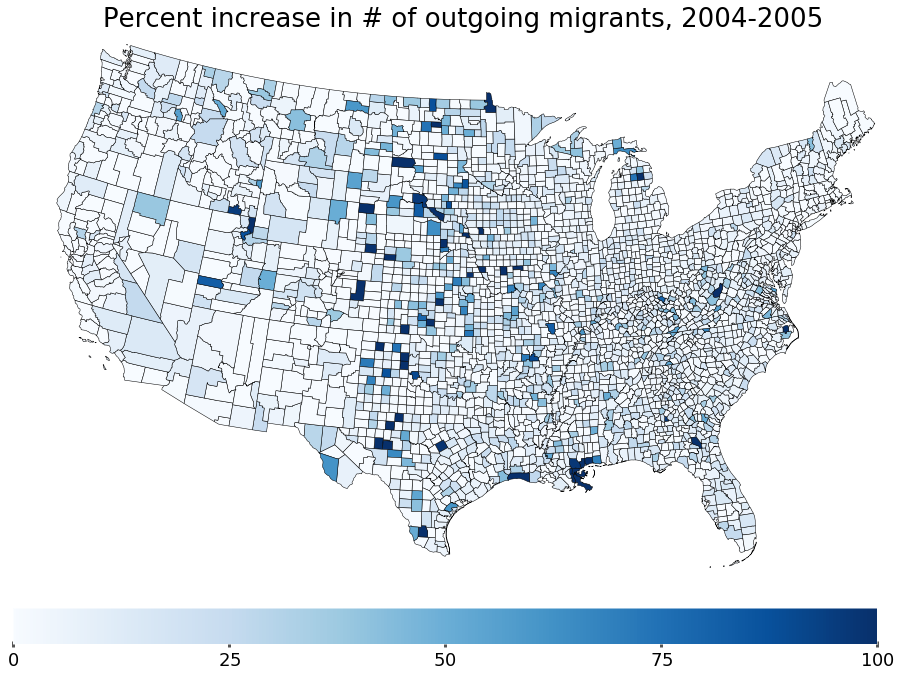

In [11]:
simpleMap(
    shapefileFn,
    shapefileKey,
    {
        county: percent_increase_outgoing[i] * 100
        for i, county in enumerate(migration_counties)
    },
    #outputFn="outgoing.png",
    bounds=[22, 49, -119, -64],
    title="Percent increase in # of outgoing migrants, 2004-2005",
    colorbarRange=(0, 100),
    logScale=False,
)

## Find affected counties

In [13]:
f = open("data/usa_coastal_counties.csv","r")
coastal_county_set = set(map(lambda x: "%05d" % (int(x.split("|")[0])), f.read().strip().split("\n")))
f.close()

In [14]:
coastal_county_idxs = set()
for i,county in enumerate(migration_counties):
    if county in coastal_county_set:
        coastal_county_idxs.add(i)

In [47]:
map_data = {}
print("year,county fips,previous number of outgoing migrants,new number of outgoing migrants,percent increase,population")
for i in range(1, len(migration_data)):    
    percent_increase = calculate_percent_increase(outgoing_migration_data[i-1], outgoing_migration_data[i])
    
    for j in np.argsort(percent_increase)[::-1]:
        prev_num_outgoing = np.sum(outgoing_migration_data[i-1][j])
        new_num_outgoing = np.sum(outgoing_migration_data[i][j])
        population  = populationVectors[i][j,0]
        county_idx = migration_counties[j]
        
        if j in coastal_county_idxs and new_num_outgoing > 1000 and percent_increase[j] >= 1 and i != 7:
            print(",".join(map(str,[
                2004+i,
                county_idx,
                prev_num_outgoing,
                new_num_outgoing,
                percent_increase[j],
                population
            ])))
            map_data[county_idx] = 1
        
        if percent_increase[j] < 1:
            break

year,county fips,previous number of outgoing migrants,new number of outgoing migrants,percent increase,population
2005,22087,1939,26554,12.694687983496648,71300
2005,22071,19385,139212,6.181428939901986,494294
2005,22023,252,1158,3.5952380952380953,9846
2005,22075,1226,4488,2.66068515497553,29558
2005,28045,1284,3410,1.6557632398753894,47715
2005,22051,19658,48169,1.4503510021365347,456554
2005,28047,8016,18730,1.3365768463073853,197784
2006,13179,3015,6383,1.1170812603648426,63047


/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


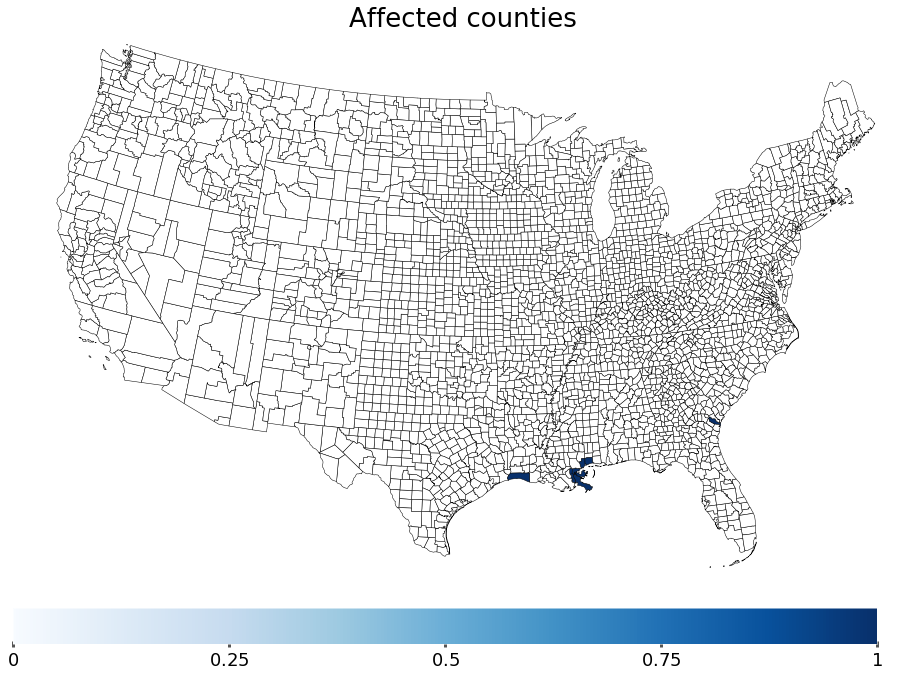

In [48]:
simpleMap(
    shapefileFn,
    shapefileKey,
    map_data,
    bounds=[22, 49, -119, -64],
    title="Affected counties",
    colorbarRange=(0, 1),
    logScale=False,
)